In [19]:
# Section must be included at the beginning of each new notebook. Remember to change the app name. 
# If you're using VirtualBox, change the below to '/home/user/spark-2.1.1-bin-hadoop2.7'
import findspark
findspark.init('/home/ubuntu/spark-2.1.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('sharingBikeDatamining').getOrCreate()

In [20]:
import pylab
import calendar
import numpy as np
import pandas as pd
import seaborn as sn
from scipy import stats
import missingno as msno
from datetime import datetime
import matplotlib.pyplot as plt
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

In [31]:
dailyData = pd.read_csv('/home/ubuntu/sharing-bike-data-mining/hour.csv')

In [32]:
# variables data type
dailyData.dtypes

instant         int64
dteday         object
season          int64
yr              int64
mnth            int64
hr              int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object

In [33]:
dailyData["season"] = dailyData.season.map({1: "Spring", 2 : "Summer", 3 : "Fall", 4 :"Winter" })

dailyData["weather"] = dailyData.weathersit.map({1: " Clear + Few clouds + Partly cloudy + Partly cloudy",\
                                        2 : " Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist ", \
                                        3 : " Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds", \
                                        4 :" Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog " })

In [34]:
#Coercing To Category Type
categoryVariableList = ["hr","weekday","mnth","season","weathersit","holiday","workingday"]
for var in categoryVariableList:
    dailyData[var] = dailyData[var].astype("category")

[Text(0,0.5,'Count'),
 Text(0.5,0,'variableTypeariable Type'),
 Text(0.5,1,'Variables DataType Count')]

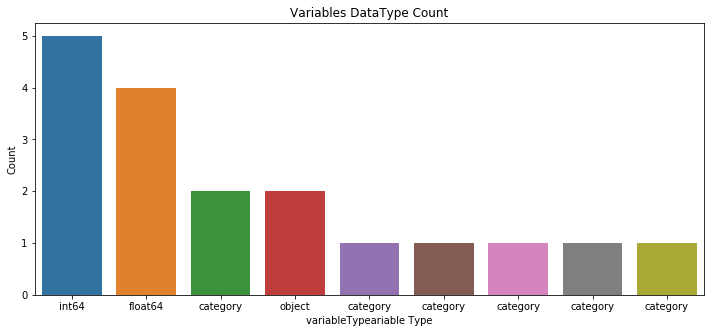

In [35]:
dataTypeDf = pd.DataFrame(dailyData.dtypes.value_counts()).reset_index().rename(columns={"index":"variableType",0:"count"})
fig,ax = plt.subplots()
fig.set_size_inches(12,5)
sn.barplot(data=dataTypeDf,x="variableType",y="count",ax=ax)
ax.set(xlabel='variableTypeariable Type', ylabel='Count',title="Variables DataType Count")

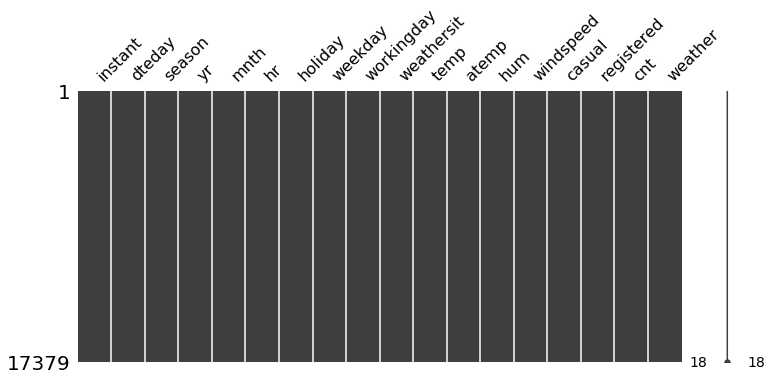

In [36]:
# missing value detect
msno.matrix(dailyData,figsize=(12,5))

[Text(0,0.5,'Count'),
 Text(0.5,0,'Working Day'),
 Text(0.5,1,'Box Plot On Count Across Working Day')]

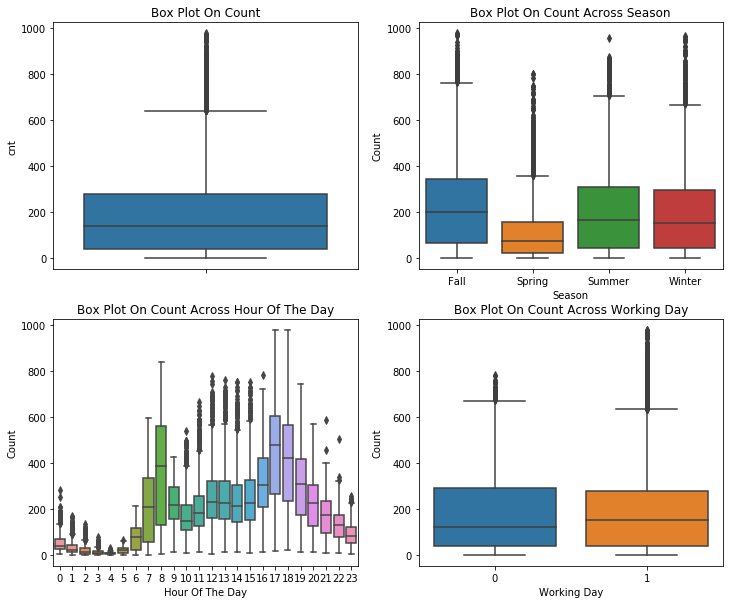

In [37]:
fig, axes = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(12, 10)
sn.boxplot(data=dailyData,y="cnt",orient="v",ax=axes[0][0])
sn.boxplot(data=dailyData,y="cnt",x="season",orient="v",ax=axes[0][1])
sn.boxplot(data=dailyData,y="cnt",x="hr",orient="v",ax=axes[1][0])
sn.boxplot(data=dailyData,y="cnt",x="workingday",orient="v",ax=axes[1][1])

axes[0][0].set(ylabel='cnt',title="Box Plot On Count")
axes[0][1].set(xlabel='Season', ylabel='Count',title="Box Plot On Count Across Season")
axes[1][0].set(xlabel='Hour Of The Day', ylabel='Count',title="Box Plot On Count Across Hour Of The Day")
axes[1][1].set(xlabel='Working Day', ylabel='Count',title="Box Plot On Count Across Working Day")

In [38]:
#  Remove Outliers In The Count Column
dailyDataWithoutOutliers = dailyData[np.abs(dailyData["cnt"]-dailyData["cnt"].mean())<=(3*dailyData["cnt"].std())] 
print ("Shape Of The Before Ouliers: ",dailyData.shape)
print ("Shape Of The After Ouliers: ",dailyDataWithoutOutliers.shape)

Shape Of The Before Ouliers:  (17379, 18)
Shape Of The After Ouliers:  (17135, 18)


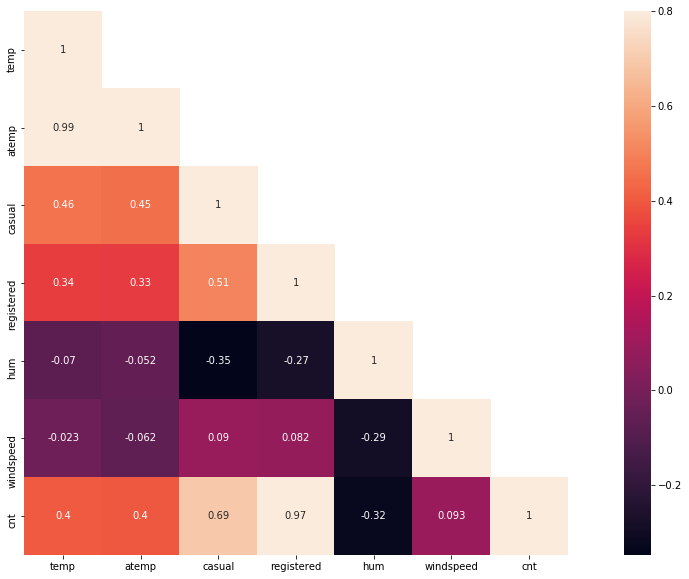

In [39]:
# Correlation Analysis
corrMatt = dailyData[["temp","atemp","casual","registered","hum","windspeed","cnt"]].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sn.heatmap(corrMatt, mask=mask,vmax=.8, square=True,annot=True)

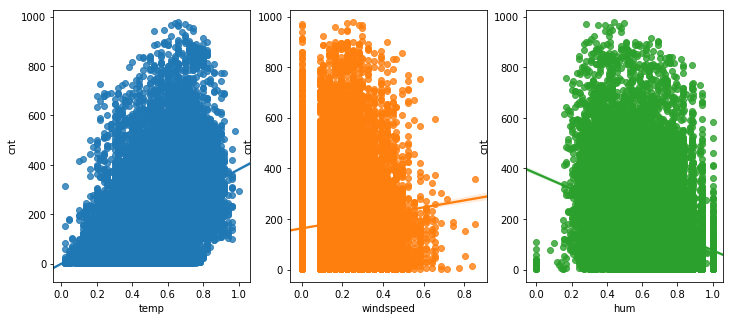

In [40]:
fig,(ax1,ax2,ax3) = plt.subplots(ncols=3)
fig.set_size_inches(12, 5)
sn.regplot(x="temp", y="cnt", data=dailyData,ax=ax1)
sn.regplot(x="windspeed", y="cnt", data=dailyData,ax=ax2)
sn.regplot(x="hum", y="cnt", data=dailyData,ax=ax3)

((array([-3.94171042, -3.72363151, -3.60421718, ...,  3.60421718,
          3.72363151,  3.94171042]),
  array([0.69314718, 0.69314718, 0.69314718, ..., 6.5971457 , 6.5971457 ,
         6.59850903])),
 (1.3490324630370492, 4.544366339498316, 0.9601811537292394))

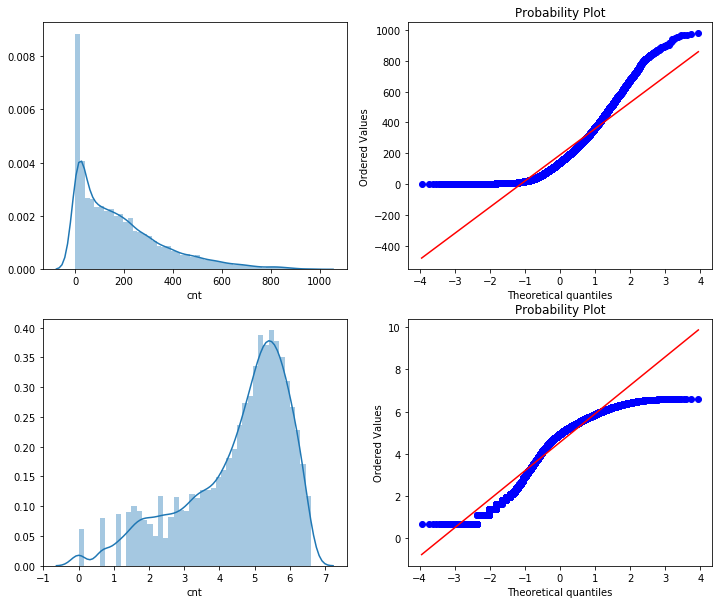

In [41]:
# Visualizing Distribution Of Data
fig,axes = plt.subplots(ncols=2,nrows=2)
fig.set_size_inches(12, 10)
sn.distplot(dailyData["cnt"],ax=axes[0][0])
stats.probplot(dailyData["cnt"], dist='norm', fit=True, plot=axes[0][1])
sn.distplot(np.log(dailyDataWithoutOutliers["cnt"]),ax=axes[1][0])
stats.probplot(np.log1p(dailyDataWithoutOutliers["cnt"]), dist='norm', fit=True, plot=axes[1][1])

[Text(0,0.5,'Users Count'),
 Text(0.5,0,'Hour Of The Day'),
 Text(0.5,1,'Average Users Count By Hour Of The Day Across User Type'),
 None]

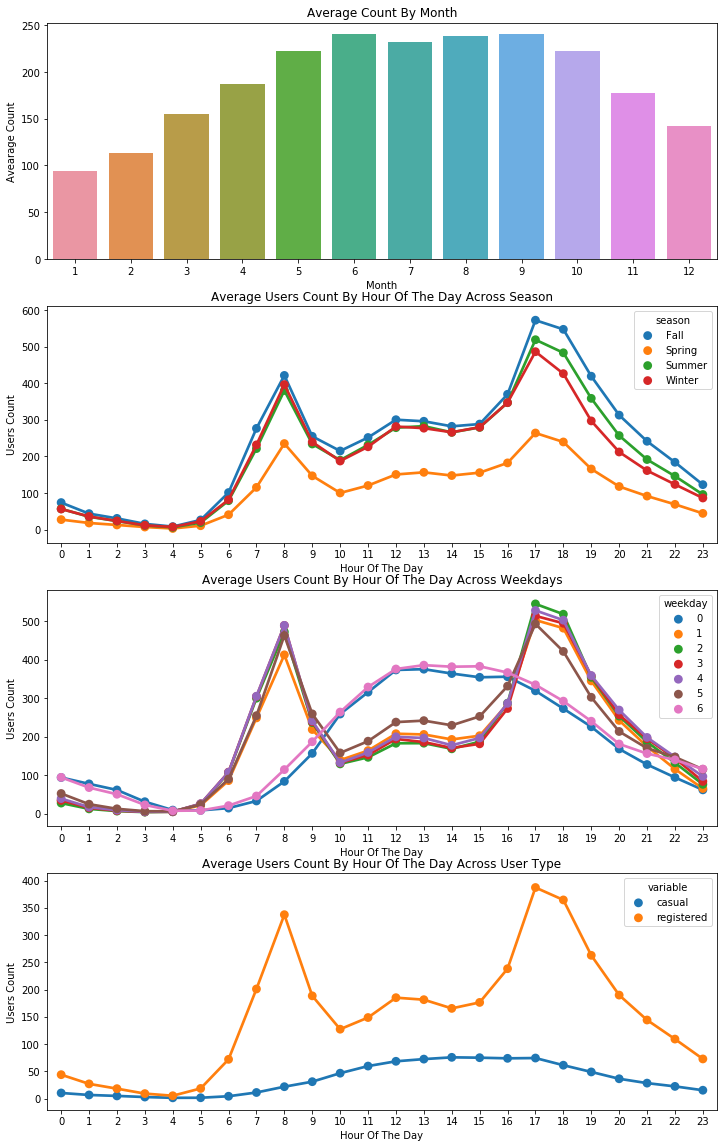

In [42]:
fig,(ax1,ax2,ax3,ax4)= plt.subplots(nrows=4)
fig.set_size_inches(12,20)
sortOrder = ["January","February","March","April","May","June","July","August","September","October","November","December"]
hueOrder = ["Sunday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday"]

### ax 1 ###
monthAggregated = pd.DataFrame(dailyData.groupby("mnth")["cnt"].mean()).reset_index()
monthSorted = monthAggregated.sort_values(by="cnt",ascending=False)
sn.barplot(data=monthSorted,x="mnth",y="cnt", ax = ax1)
ax1.set(xlabel='Month', ylabel='Avearage Count',title="Average Count By Month")


### ax 2 ###
hourAggregated = pd.DataFrame(dailyData.groupby(["hr","season"],sort=True)["cnt"].mean()).reset_index()
sn.pointplot(x=hourAggregated["hr"], y=hourAggregated["cnt"],hue=hourAggregated["season"], data=hourAggregated, join=True,ax=ax2)
ax2.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across Season",label='big')


## ax 3 ###
hourAggregated = pd.DataFrame(dailyData.groupby(["hr","weekday"],sort=True)["cnt"].mean()).reset_index()
sn.pointplot(x=hourAggregated["hr"], y = hourAggregated["cnt"],hue = hourAggregated["weekday"], data = hourAggregated, join=True,ax=ax3)
ax3.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across Weekdays",label='big')


## ax 4 ###
hourTransformed = pd.melt(dailyData[["hr","casual","registered"]], id_vars=['hr'], value_vars=['casual', 'registered'])
hourAggregated = pd.DataFrame(hourTransformed.groupby(["hr","variable"],sort=True)["value"].mean()).reset_index()
sn.pointplot(x=hourAggregated["hr"], y=hourAggregated["value"],hue=hourAggregated["variable"], data=hourAggregated, join=True,ax=ax4)
ax4.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across User Type",label='big')

In [71]:
a = dailyData.dtypes
dailyData["weather"]

0         Clear + Few clouds + Partly cloudy + Partly c...
1         Clear + Few clouds + Partly cloudy + Partly c...
2         Clear + Few clouds + Partly cloudy + Partly c...
3         Clear + Few clouds + Partly cloudy + Partly c...
4         Clear + Few clouds + Partly cloudy + Partly c...
5         Mist + Cloudy, Mist + Broken clouds, Mist + F...
6         Clear + Few clouds + Partly cloudy + Partly c...
7         Clear + Few clouds + Partly cloudy + Partly c...
8         Clear + Few clouds + Partly cloudy + Partly c...
9         Clear + Few clouds + Partly cloudy + Partly c...
10        Clear + Few clouds + Partly cloudy + Partly c...
11        Clear + Few clouds + Partly cloudy + Partly c...
12        Clear + Few clouds + Partly cloudy + Partly c...
13        Mist + Cloudy, Mist + Broken clouds, Mist + F...
14        Mist + Cloudy, Mist + Broken clouds, Mist + F...
15        Mist + Cloudy, Mist + Broken clouds, Mist + F...
16        Mist + Cloudy, Mist + Broken clouds, Mist + F.

In [73]:
dailyData["season"] = dailyData.season.map({ "Spring" : 1, "Summer" : 2, "Fall" : 3, "Winter" : 4 })

dailyData["weather"] = dailyData.weathersit.map({ " Clear + Few clouds + Partly cloudy + Partly cloudy" : 1,\
                                       " Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist " : 2, \
                                       " Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds" : 3, \
                                       " Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog " : 4 })

### convert panadas data frame into spark data frame

In [74]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(spark)
spark_dailyData = sqlContext.createDataFrame(dailyData)

In [77]:
spark_dailyData

DataFrame[instant: bigint, dteday: string, season: double, yr: bigint, mnth: bigint, hr: bigint, holiday: bigint, weekday: bigint, workingday: bigint, weathersit: bigint, temp: double, atemp: double, hum: double, windspeed: double, casual: bigint, registered: bigint, cnt: bigint, weather: double]

### Spliting data into test data and train data

In [79]:
from pyspark.ml.feature import VectorAssembler
vectorAssembler = VectorAssembler(inputCols = ['season', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'windspeed', 'casual', 'registered', 'weather'], outputCol = 'features')
sharingbike_df = vectorAssembler.transform(spark_dailyData)
sharingbike_df.

[Row(instant=1, dteday='2011-01-01', season=nan, yr=0, mnth=1, hr=0, holiday=0, weekday=6, workingday=0, weathersit=1, temp=0.24, atemp=0.2879, hum=0.81, windspeed=0.0, casual=3, registered=13, cnt=16, weather=nan, features=DenseVector([nan, 0.0, 6.0, 0.0, 1.0, 0.24, 0.0, 3.0, 13.0, nan]))]